In [1]:
cd ..

C:\Users\giaco\thesis-sbp-abm\municipality_level_analysis\municipalities_abm


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import csv

from municipalities_abm.model import SBPAdoption

In [3]:
%matplotlib inline

mpl.rc('axes', labelsize=14)

tick_size = 11
mpl.rc('xtick', labelsize=tick_size)
mpl.rc('ytick', labelsize=tick_size)

In [4]:
# Line necessary to import agents in model, since the cwd of the notebook server is always the base path where you started the 
# server 
import sys
sys.path.append(".\municipalities_abm_all_feats")

In [5]:
# How to display floats
pd.options.display.float_format = '{:.6f}'.format
#np.set_printoptions(precision=6)
np.set_printoptions(formatter={'float': lambda x: "{0:0.6f}".format(x)})

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "model_validation"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=False, fig_extension="jpeg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Real data loading

In [7]:
path_to_adoption_port_real = "./model_validation/data/SBP yearly adoption - Portugal.csv"
yearly_adoption_portugal_real = pd.read_csv(path_to_adoption_port_real, index_col=0)
yearly_adoption_portugal_real.drop(1995, inplace=True)

In [8]:
path_to_adoption_munic_real = "./model_validation/data/SBP yearly adoption - Municipalities.csv"
munic_yearly_adoption_real = pd.read_csv(path_to_adoption_munic_real, index_col=['Municipality', 'Year'])

# Model runs variables to specify

In [9]:
n_runs = 100

In [10]:
start_year = 1996
stop_year = 2021

# Load model output

In [11]:
path_to_model_results = "./model_validation/FINAL RUNS/nl_svm & nl_svm"

In [12]:
munic_yearly_adoption = pd.read_csv(os.path.join(path_to_model_results, "output\municipalities_yearly_adoption.csv"),
                                   index_col=['Municipality', 'Year'])
yearly_adoption_portugal_pred = pd.read_csv(os.path.join(path_to_model_results, "output\portugal_yearly_adoption.csv"),
                                           index_col=['Year'])
cumulative_adoption_portugal_pred = pd.read_csv(os.path.join(path_to_model_results, "output\portugal_cumulative_adoption.csv"),
                                               index_col=['Year'])

# Plot of runs and average value over real adoption

In [13]:
import scipy.stats

def plot_adoption_trend_multiple_runs_lines(predicted_adoption, real_adoption, max_y, fig_title):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(10, 5)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Hectares", fontsize=16)
    ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.1)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_vals = pred_adoption_av.values
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'b--', linewidth=2, marker='.', markersize=9,
               label='Average predicted adoption')    
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed adoption')
    ax_pr.legend(loc='best')
    
    save_fig((fig_title))  

In [14]:
import scipy.stats as st

def plot_adoption_trend_multiple_runs(predicted_adoption, real_adoption, max_y, fig_title, confidence=0.95):
    """
    Function to plot all the predicted adoptions, the average predicted and the real, in the same graph and save the figure.
    The predicted adoption and real adoption must be pandas Series or DataFrame with as index the years.
    """
    # Base figure
    fig_pr, ax_pr = plt.subplots()
    fig_pr.set_size_inches(8, 4)
    ax_pr.set_xlabel("Years", fontsize=16)
    ax_pr.set_ylabel("Area installed [ha]", fontsize=16)
    #ax_pr.set_title(fig_title, fontsize=18)
    ax_pr.set_xlim(predicted_adoption.index[0], predicted_adoption.index[-1])
    xticks = [year for year in predicted_adoption.index if year%2 == 0]
    ax_pr.set_xticks(xticks)
    ax_pr.set_ylim(0, max_y)
    ax_pr.grid(True)

    # Plot adoptions
    for col in predicted_adoption.columns:
        ax_pr.plot(predicted_adoption.index, predicted_adoption[col].values, 'b:', linewidth=1, alpha=0.1)
    ci = []
    for index, row in predicted_adoption.iterrows():
        #m, se = np.mean(row), scipy.stats.sem(row)
        #ci.append(se * scipy.stats.t.ppf((1 + confidence) / 2., len(row)-1))
        ci.append(1.96 * np.std(row)/np.sqrt(n_runs))
    ci = np.array(ci)
    pred_adoption_av = predicted_adoption.mean(axis=1)
    pred_vals = pred_adoption_av.values
    ax_pr.plot(real_adoption.index, real_adoption.values, 'r--', linewidth=2, marker='.', markersize=9,
               label='Observed')
    ax_pr.plot(pred_adoption_av.index, pred_vals, 'b--', linewidth=2, marker='.', markersize=9,
               label='Estimated')    
    ax_pr.legend(loc='best', fontsize=12)
    
    ax_pr.fill_between(pred_adoption_av.index, (pred_vals-ci), (pred_vals+ci), color='b', alpha=.1)
    
    save_fig((fig_title))  

#### Plot predicted vs real adoption in Portugal

Saving figure Yearly SBP adoption in Portugal


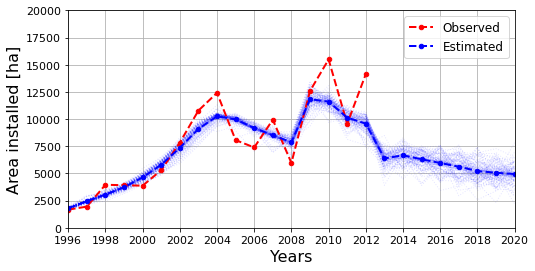

In [15]:
title = "Yearly SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(yearly_adoption_portugal_pred, yearly_adoption_portugal_real, 20000, title, confidence=0.95)

#### Plot predicted vs real cumulative adoption in Portugal

In [16]:
cumulative_adoption_portugal_real = yearly_adoption_portugal_real.cumsum()

Saving figure Cumulative SBP adoption in Portugal


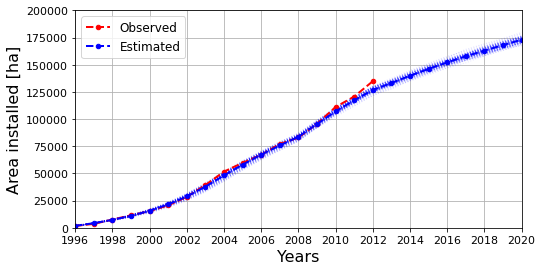

In [17]:
title = "Cumulative SBP adoption in Portugal"
plot_adoption_trend_multiple_runs(cumulative_adoption_portugal_pred, cumulative_adoption_portugal_real, 200000, title)

# Model validation based on average values

In [18]:
munic_yearly_adoption_av = munic_yearly_adoption.mean(axis=1)
munic_yearly_adoption_av.name = "predicted_adoption"

In [19]:
yearly_adoption_portugal_pred_av = yearly_adoption_portugal_pred.mean(axis=1)

In [20]:
cumulative_adoption_portugal_pred_av = cumulative_adoption_portugal_pred.mean(axis=1)

## Macro-validation

### Quantitative

Saving figure Yearly predicted vs. observed adoption


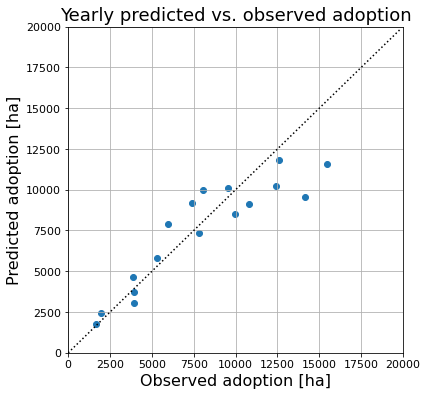

In [21]:
fig_title = "Yearly predicted vs. observed adoption"
fig_pr, ax_pr = plt.subplots()
fig_pr.set_size_inches(6, 6)
ax_pr.set_xlabel("Observed adoption [ha]", fontsize=16)
ax_pr.set_ylabel("Predicted adoption [ha]", fontsize=16)
ax_pr.set_title(fig_title, fontsize=18)
lim = 20000
ax_pr.set_xlim(0, lim)
ax_pr.set_ylim(0, lim)
ax_pr.grid(True)
# Add diagonal
p = np.arange(0, lim, 100)
ax_pr.plot(p, p, 'k:')

yearly_adoption_portugal_pred_av_untill_2012 = yearly_adoption_portugal_pred_av.loc[
    yearly_adoption_portugal_pred_av.index <= 2012
]
ax_pr.scatter(yearly_adoption_portugal_real.values, yearly_adoption_portugal_pred_av_untill_2012.values)
save_fig((fig_title))  

In [22]:
def adjusted_r2(r2, n, p):
    return 1-(1-r2)*(n-1)/(n-p-1)

In [23]:
real_for_macro_metrics = yearly_adoption_portugal_real
pred_for_macro_metrics = yearly_adoption_portugal_pred_av_untill_2012

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(real_for_macro_metrics.values, pred_for_macro_metrics))
rrmse = rmse / real_for_macro_metrics.values.std()
mae = mean_absolute_error(real_for_macro_metrics.values, pred_for_macro_metrics)
r2 = r2_score(real_for_macro_metrics.values, pred_for_macro_metrics)
adj_r2 = adjusted_r2(r2, len(munic_yearly_adoption_av), 25)
print("Cumulative adoption score:")
rmse_str = "RMSE: " + str(rmse)
print(rmse_str)
rrmse_str = "Relative RMSE: " + str(rrmse)
print(rrmse_str)
mae_str = "MAE: " + str(mae)
print(mae_str)
adj_r2_str = "Adjusted R2: " + str(adj_r2)
print(adj_r2_str)
print(r2)

with open("model_validation/images/Macro-validation metrics.csv", "w+", newline ='') as file:
    to_print = [[rmse_str], [rrmse_str], [mae_str], [adj_r2_str],]
    wr = csv.writer(file)
    wr.writerows(to_print)

Cumulative adoption score:
RMSE: 1861.2201713960867
Relative RMSE: 0.45325833814582356
MAE: 1416.2617545121757
Adjusted R2: 0.7937604642590986
0.7945568789012862


## Micro-validation

Create dataframe with both real and predicted adoption between the starting year of the simulation and 2012, or the ending years of the simulation if it is before 2012.

(Note that for validation purposes the years will always been between 1996 and 2012, unless we want the error only on PCF project years)

### Quantitative

In [25]:
start_year = 1996

In [26]:
munic_adoption_real_pred = pd.concat([munic_yearly_adoption_real['adoption_in_year'], munic_yearly_adoption_av],
                                      axis=1, join='inner')
final_year_val = 2012
to_drop = munic_adoption_real_pred.loc[(munic_adoption_real_pred.index.get_level_values(1) < start_year)
                                       | (munic_adoption_real_pred.index.get_level_values(1) > final_year_val)].index
munic_adoption_real_pred.drop(to_drop, inplace=True)

In [27]:
from IPython.display import display

def get_yearly_and_cumul_rmse(adoption_rp):
    years = adoption_rp.index.get_level_values(1).unique()
    rmse_pd = pd.DataFrame(index=['RMSE on year', 'Relative RMSE on year', 'RMSE till year', 'Relative RMSE till year'],
                           columns=years)
    for year in years:
        real = adoption_rp.loc[(slice(None), year),'adoption_in_year'].values
        pred = adoption_rp.loc[(slice(None), year),'predicted_adoption'].values
        y_mse = mean_squared_error(real, pred)
        rmse_pd.loc['RMSE on year', year] = np.sqrt(y_mse)
        rmse_pd.loc['Relative RMSE on year', year] = np.sqrt(y_mse) / real.std()
        
        real_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'adoption_in_year'].values
        pred_c = adoption_rp.loc[(slice(None), np.arange(start_year, year+1)),'predicted_adoption'].values
        y_mse_c = mean_squared_error(real_c, pred_c)
        rmse_pd.loc['RMSE till year', year] = np.sqrt(y_mse_c)
        rmse_pd.loc['Relative RMSE till year', year] = np.sqrt(y_mse_c) / real_c.std()
    
    display(rmse_pd)
    rmse_pd.T[['RMSE on year', 'RMSE till year']].plot()
    rmse_pd.T[['Relative RMSE on year', 'Relative RMSE till year']].plot()

In [28]:
def micro_validation(pred_adoption_runs, adoption_rp):
    real = adoption_rp['adoption_in_year'].values
    
    rmses = []
    rrmses = []
    maes = []
    adj_r2s = []
    
    for (_, pred) in pred_adoption_runs.iteritems(): 
        mse = mean_squared_error(real, pred)
        rmse = np.sqrt(mse)
        rrmse = rmse / real.std()
        rmses.append(rmse)
        rrmses.append(rrmse)
        
        mae = mean_absolute_error(real, pred)
        maes.append(mae)

        r2 = r2_score(real, pred)
        adj_r2 = adjusted_r2(r2, len(real), 25) # Taken number of features with sbp payments 
        adj_r2s.append(adj_r2)
        
    pred = adoption_rp['predicted_adoption'].values
    mse = mean_squared_error(real, pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / real.std()
    rmse_str = "Average total RMSE: " + str(rmse)
    rmse_str_2 = "Total RMSE standard deviation: " + str(np.std(rmses))
    #print(str(np.mean(rmses)))
    print(rmse_str)
    print(rmse_str_2)
    rrmse_str = "Average total relative RMSE: " + str(rrmse)
    rrmse_str_2 = "Total relative RMSE standard deviation: " + str(np.std(rrmses))
    #print(np.mean(rrmses))
    print(rrmse_str)
    print(rrmse_str_2)
    mae = mean_absolute_error(real, pred)
    mae_str = "Average total MAE: " + str(mae)
    mae_str_2 = "Total MAE standard deviation: " + str(np.std(maes))
    #print(str(np.mean(maes)))
    print(mae_str)
    print(mae_str_2)
    r2 = r2_score(real, pred)
    adj_r2 = adjusted_r2(r2, len(real), 25) # Taken number of features for sbp payments
    #print(str(np.mean(adj_r2s)))
    adj_r2_str = "Average total adjusted R2 score: " + str(adj_r2)
    adj_r2_str_2 = "Total adjusted R2 score standard deviation: " + str(np.std(adj_r2))
    print(adj_r2_str)
    print(adj_r2_str_2)
    
    with open("model_validation/images/Micro-validation metrics and non adopters.csv", "w+", newline ='') as file:
        to_print = [[rmse_str], [rmse_str_2], [rrmse_str], [rrmse_str_2],
                    [mae_str], [mae_str_2], [adj_r2_str], [adj_r2_str_2]]
        wr = csv.writer(file)
        wr.writerows(to_print)
        
    get_yearly_and_cumul_rmse(adoption_rp)

Average total RMSE: 0.008012177240042325
Total RMSE standard deviation: 0.00011190691722884164
Average total relative RMSE: 0.802916996770574
Total relative RMSE standard deviation: 0.011214425643279959
Average total MAE: 0.002243640957827804
Total MAE standard deviation: 8.671698591150654e-05
Average total adjusted R2 score: 0.3516421184142223
Total adjusted R2 score standard deviation: 0.0


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
RMSE on year,0.004608,0.004020,0.002301,0.004281,0.004757,0.003669,0.005579,0.004361,0.005420,0.007428,0.003962,0.006969,0.003411,0.008557,0.017785,0.010902,0.016590
Relative RMSE on year,0.959017,0.927188,0.627437,0.856254,0.900944,0.733840,0.745300,0.605393,0.624520,0.729555,0.788457,0.593687,0.509959,0.762689,0.883560,0.891248,0.897563
RMSE till year,0.004608,0.004324,0.003772,0.003906,0.004090,0.004023,0.004280,0.004290,0.004430,0.004815,0.004743,0.004967,0.004865,0.005216,0.006818,0.007142,0.008012
Relative RMSE till year,0.959017,0.944844,0.876728,0.870035,0.876991,0.849971,0.816077,0.761481,0.725162,0.724043,0.727485,0.691987,0.680511,0.694204,0.762378,0.777721,0.802917


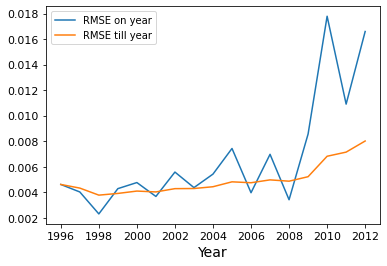

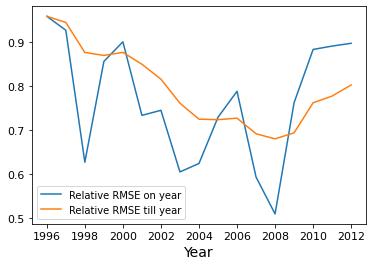

In [29]:
munic_yearly_adoption_untill_2012 = munic_yearly_adoption.loc[munic_yearly_adoption.index.get_level_values('Year') <= 2012]
micro_validation(munic_yearly_adoption_untill_2012, munic_adoption_real_pred)

### Qualitative

In [30]:
munic_adoption_real_pred_dist = munic_adoption_real_pred.copy()
munic_adoption_real_pred_dist.rename(columns={"adoption_in_year": "Observed adoption",
                                              "predicted_adoption": "Predicted adoption"}, inplace=True)

#### Number of predicted adopters over time

In [31]:
mask_real = munic_adoption_real_pred_dist['Observed adoption'] > 0
real_yearly_adopters = (munic_adoption_real_pred_dist['Observed adoption'] > 0).astype(int).groupby('Year').sum()

# For prediction cannot use the averaged data --> need to do the average of the adopters in each run
pred_yearly_adopters = (munic_yearly_adoption > 0).astype(int).groupby('Year').sum()
pred_yearly_adopters_av = pred_yearly_adopters.mean(axis=1)

Saving figure Number of municipalities with adoption over time


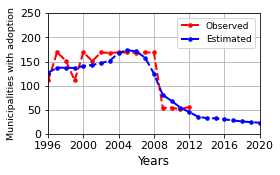

In [32]:
# Base figure
fig_title = 'Number of municipalities with adoption over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(4, 2.5)
ax_ad.set_xlabel("Years", fontsize=12)
ax_ad.set_ylabel("Municipalities with adoption", fontsize=9.5)
ax_ad.set_xlim(pred_yearly_adopters.index[0], pred_yearly_adopters.index[-1])
xticks = [year for year in pred_yearly_adopters.index if year%4 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 250)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_yearly_adopters.index, real_yearly_adopters.values, 'r--', linewidth=2, marker='.', markersize=7,
           label='Observed')
ax_ad.plot(pred_yearly_adopters_av.index, pred_yearly_adopters_av.values, 'b--', linewidth=2, marker='.', markersize=7,
           label='Estimated')
ax_ad.legend(loc='best', fontsize=9)

save_fig((fig_title), tight_layout=True)

#### Average adoption of only adopters over time

In [33]:
pred_av_yearly_adoption = (yearly_adoption_portugal_pred_av / pred_yearly_adopters_av)
real_av_yearly_adoption = (yearly_adoption_portugal_real['Yearly adoption'] / real_yearly_adopters)

Saving figure Average adoption of municipalities adopting over time


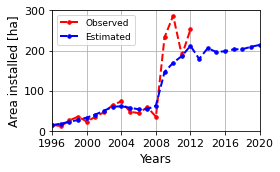

In [34]:
# Base figure
fig_title = 'Average adoption of municipalities adopting over time'
fig_ad, ax_ad = plt.subplots()
fig_ad.set_size_inches(4, 2.5)
ax_ad.set_xlabel("Years", fontsize=12)
ax_ad.set_ylabel("Area installed [ha]", fontsize=12)
#ax_ad.set_title(fig_title, fontsize=18)
ax_ad.set_xlim(pred_av_yearly_adoption.index[0], pred_av_yearly_adoption.index[-1])
xticks = [year for year in pred_av_yearly_adoption.index if year%4 == 0]
ax_ad.set_xticks(xticks)
ax_ad.set_ylim(0, 300)
ax_ad.grid(True)

# Plot adoptions
ax_ad.plot(real_av_yearly_adoption.index, real_av_yearly_adoption.values, 'r--', linewidth=2, marker='.', markersize=7,
           label='Observed')
ax_ad.plot(pred_av_yearly_adoption.index, pred_av_yearly_adoption.values, 'b--', linewidth=2, marker='.', markersize=7,
           label='Estimated')
ax_ad.legend(loc='best', fontsize=9)

save_fig((fig_title), tight_layout=True)

#### Ditribution of adoption in each year in each municipality

In [35]:
num_0_real = (munic_adoption_real_pred_dist["Observed adoption"] == 0).astype(int).sum()
num_0_real_str = "Total OBSERVED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_real)
print(num_0_real_str)

pred_yearly_non_adopters = (munic_yearly_adoption == 0).astype(int).groupby('Year').sum()
pred_yearly_non_adopters_av = pred_yearly_adopters.mean(axis=1)
num_0_pred = round(pred_yearly_non_adopters_av.sum(), 0).astype(int)
num_0_pred_str = "Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: " + str(num_0_pred)
print(num_0_pred_str)

with open("model_validation/images/Micro-validation metrics and non adopters.csv", "a", newline ='') as file:
    to_print = [" ", [num_0_real_str], [num_0_pred_str]]
    wr = csv.writer(file)
    wr.writerows(to_print)

Total OBSERVED number of times any municipality does NOT adopt 1996-2012: 2144
Average total PREDICTED number of times any municipality does NOT adopt 1996-2012: 2396


Saving figure Distribution of municipalities' adoption


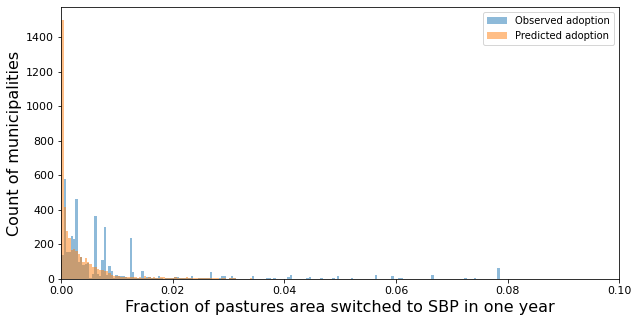

In [36]:
fig_title = "Distribution of municipalities' adoption"
munic_adoption_real_pred_dist.replace(0, None, inplace=True) # To avoid plotting 0s
ax = munic_adoption_real_pred_dist.plot.hist(figsize=(10, 5), bins=500, alpha=0.5) 
ax.set_xlabel("Fraction of pastures area switched to SBP in one year", fontsize=16)
ax.set_ylabel("Count of municipalities", fontsize=16)
ax.set_xlim(0, 0.1)
#ax.set_title("Distribution of municipalities' adoption", fontsize=18)
ax_ad.legend(loc='best', fontsize=12)
save_fig((fig_title))

In [37]:
munic_adoption_real_pred_dist['Predicted adoption'].describe()

count   4403.000000
mean       0.003306
std        0.005216
min        0.000000
25%        0.000197
50%        0.001275
75%        0.004229
max        0.043870
Name: Predicted adoption, dtype: float64

#### Map based on adoption level for each municipality at the end of the simulation

In [38]:
# Collect observed adoption in year
geometry = pred_for_map['geometry']
munic_map_adoption_real = munic_yearly_adoption_real.loc[munic_yearly_adoption_real.index.get_level_values(1) == year_for_map]
munic_map_adoption_real.index = munic_map_adoption_real.index.droplevel(1)

real_for_map = pd.concat([munic_map_adoption_real['tot_cumul_adoption_until_year_ha'], geometry], axis=1)
real_for_map = gpd.GeoDataFrame(real_for_map)

NameError: name 'pred_for_map' is not defined

Plot of area adopted in hectares

In [ ]:
import contextily as ctx
import matplotlib

def plot_maps_no_0s(geodata, column_data, leg_label, fig_title):
    """
    To plot maps side by side.
    Inputs to be given as lists of two elements, the first referring to the predicted adoption and the second to the
    observed one.
    
    For additional options for plotting with geopandas see https://geopandas.org/mapping.html
    For different backgrounds see https://contextily.readthedocs.io/en/latest/providers_deepdive.html
    """
    fig, axis = plt.subplots(ncols=len(geodata), figsize=(15, 8))
    #fig.suptitle(fig_title, fontsize=18)

    for i in range(len(geodata)):
        geodata_no_0 = geodata[i].loc[geodata[i][column_data[i]] != 0]
        geodata_no_0.crs = "EPSG:3857"
        transparency = 0.8
        if i == 0: # Legend scale based on predicted values
            sc_min = 10
            sc_max = max(geodata_no_0['Total cumulative adoption [ha]']) 
        geodata_no_0.plot(ax=axis[i], column=column_data[i],
                          cmap="OrRd", #cmap='coolwarm',
                          alpha=transparency, edgecolor='k',
                          legend=True, norm=matplotlib.colors.LogNorm(vmin=sc_min, vmax=sc_max),
                          legend_kwds={'label': leg_label[i]})
        ctx.add_basemap(axis[i], source=ctx.providers.Stamen.Terrain)
        axis[i].axis('off')
        
        #geodata_0 = geodata[i].loc[geodata[i][column_data[i]] == 0]
        #geodata_0.crs = "EPSG:3857"
        #geodata_0.boundary.plot(ax=axis[i])

    save_fig((fig_title))

In [ ]:
pred_for_map

In [ ]:
pred_leg_label = "PREDICTED total area [ha] of SBP installed untill " + str(year_for_map)
real_leg_label = "OBSERVED DISAGGREGATED total area [ha] of SBP installed untill " + str(year_for_map)
plot_maps_no_0s([pred_for_map, real_for_map], ['Total cumulative adoption [ha]', 'tot_cumul_adoption_until_year_ha'],
                [pred_leg_label, real_leg_label], "Predicted vs observed adoption spatial distribution [ha]")

Plot of fraction of pastures area adopted (**Not for validation since not compared with real one move to experiments only**)

In [ ]:
import contextily as ctx

def plot_map_no_0s(geodata, column_data, leg_label):
    """
    To plot only one map.
    
    For other options for plotting with geopandas see https://geopandas.org/mapping.html
    """
    geodata_no_0 = geodata.loc[geodata[column_data] != 0]
    geodata_no_0.crs = "EPSG:3857"
    transparency = 0.6
    ax = geodata_no_0.plot(figsize=(10, 8), column=column_data,
                            cmap="OrRd", alpha=transparency, edgecolor='k',
                            legend=True,
                            legend_kwds={'label': leg_label})
    ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain)    

In [ ]:
frac_leg_label = "PREDICTED total area [fraction] of SBP installed untill " + str(year_for_map)
plot_map_no_0s(pred_for_map, 'Total cumulative adoption [fraction]', frac_leg_label)